# Homework 7

In [140]:
library(tidyverse)
library(caret)
library(MASS)
library(dplyr)
library(pROC)
library(psych)
library(viridis)


February 22, 2021

#### 1. I want you to develop a screen to test for alcohol abuse in patients with severe mental illness.  The enclosed file has a small subset of the possible predictor variables.  The last column is the gold standard.  1 = no abuse, 2 = abuse.  Will discuss the variables a bit on Monday.  Carry out an LDA and a logistic regression to classify the patients.  Use a training and a test sample.  Also compute AOC and graph the ROC.  Data are in “alc_for_class_clean”. 

educat   # years schooling <br>
race     1 = asian, 2 = black, 3 = caucasion, 4 = hispanic<br>
gender  1 = male, 2 = female<br>
marystat   1 = single (never), 2 = married, 3 = widowed, 5 = legally separated, 6 = sig other, 8 = other<br>
mmstotal  cognitive competency test  <24 is considered not competent<br>
mmsbin.   Coded into not comp/comp<br>
e1a     # drinks to pass out — 0 = don’t drink, 2 = every other answer<br>
e1_rev   # drinks to pass out — 0 = don’t drink, 1 <= 5, 2 > 5<br>
e6a    # drinks to get high<br>
f1a   # months since last abstinence from alcohol.  0 = never drink,  1 = everything else<br>
fib   Same but how many months of abstinence,  sane scale<br>
g10bin  any days >9 drinks.  0 = no, 1 = yes<br>
g16bin.   Any drinks when first awake.  Same scale<br>
sciddiag.   Type of mental illness<br>

1 = schizophrenia

2 = schizoaffective

3 = bipolar

4 = depression

5 = psychosis

6 = other

9 = missing

In [2]:
# load data
alc = read.csv('data_files//alc_for_class_clean.csv')
dim(alc)
head(alc)

[1] 219  16

educat,race,gender,marystat,mmstotal,e1a,e6a,f1a_rev,f1b_rev,age,g10bin,sciddiag,g16abin,e1_rev,mmsbin,alcabuse
7,3,2,5,22,0,0,1,0,66,0,6,1,1,1,1
10,3,1,3,28,2,2,1,0,51,0,6,2,2,2,1
11,3,2,5,0,2,0,0,0,49,0,6,1,2,1,1
8,3,2,8,25,2,0,1,0,63,0,6,1,2,2,1
16,3,2,5,13,0,0,1,0,64,0,2,1,1,1,1
18,3,2,5,23,0,0,0,0,50,0,6,1,1,1,1


In [3]:
# change 1 and 2 to 0 and 1
alc = alc %>%
      mutate(alcabuse = ifelse(alcabuse == 1,0,1))

In [4]:
# Split the data into training and test set (50% each)
set.seed(123)
training.samples = alc$alcabuse %>% 
  createDataPartition(p = 0.5, list = FALSE)
train.data  = alc[training.samples, ]
test.data = alc[-training.samples, ]

In [5]:
sum(train.data$alcabuse)
sum(test.data$alcabuse)

[1] 42

[1] 43

In [6]:
# make sure it worked
dim(train.data)
dim(na.omit(train.data))
dim(test.data)
dim(na.omit(test.data))

[1] 110  16

[1] 105  16

[1] 109  16

[1] 107  16

In [7]:
# removing rows with missing data
train.data = na.omit(train.data)
test.data = na.omit(test.data)
head(train.data)
head(test.data)

,educat,race,gender,marystat,mmstotal,e1a,e6a,f1a_rev,f1b_rev,age,g10bin,sciddiag,g16abin,e1_rev,mmsbin,alcabuse
4,8,3,2,8,25,2,0,1,0,63,0,6,1,2,2,0
6,18,3,2,5,23,0,0,0,0,50,0,6,1,1,1,0
7,11,3,2,1,20,0,0,1,0,67,0,2,2,1,1,0
13,8,3,1,5,17,2,2,1,1,36,1,2,2,2,1,0
14,16,3,1,5,29,0,0,1,1,47,0,1,1,2,2,0
17,12,3,2,3,0,0,0,0,0,53,0,9,1,1,1,0


,educat,race,gender,marystat,mmstotal,e1a,e6a,f1a_rev,f1b_rev,age,g10bin,sciddiag,g16abin,e1_rev,mmsbin,alcabuse
1,7,3,2,5,22,0,0,1,0,66,0,6,1,1,1,0
2,10,3,1,3,28,2,2,1,0,51,0,6,2,2,2,0
3,11,3,2,5,0,2,0,0,0,49,0,6,1,2,1,0
5,16,3,2,5,13,0,0,1,0,64,0,2,1,1,1,0
8,12,3,2,1,28,2,2,1,0,53,0,2,2,2,2,0
9,10,3,2,3,21,0,0,0,0,53,0,3,1,0,1,0


In [8]:
# Fit the full model for comparison
full.model <- glm(alcabuse ~., data = train.data, family = binomial)
# Summarize the final selected model
coef(full.model)

(Intercept)       educat         race       gender     marystat     mmstotal 
-4.641472998  0.003604393 -2.008048773 -0.388016304  0.057981832 -0.085388105 
         e1a          e6a      f1a_rev      f1b_rev          age       g10bin 
 0.192063245  0.123515859  2.607472273 -1.021352493 -0.001668435  1.663966733 
    sciddiag      g16abin       e1_rev       mmsbin 
 0.223336904  4.333736140  1.889148665 -0.725994794

In [11]:
# now try stepwise logisitic to help with feature selection
step.model = full.model %>% stepAIC(trace = FALSE)
coef(step.model)

(Intercept)    mmstotal     f1a_rev      g10bin    sciddiag     g16abin 
-11.6874136  -0.1064295   2.5813174   1.5300091   0.2702323   3.9864101 
     e1_rev 
  2.0335255

In [12]:
# test full model on hold out data set
#  predictions
probabilities <- full.model %>% predict(test.data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 0, 1)
# Prediction accuracy
observed.classes <- test.data$alcabuse
mean(predicted.classes == observed.classes)

[1] 0.2897196

In [13]:
# test stepwise model on hold out data
probabilities <- predict(step.model, test.data, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, 0, 1)
# Prediction accuracy
observed.classes <- test.data$alcabuse
mean(predicted.classes == observed.classes)

[1] 0.2429907

In [22]:
# compute AUC and show ROC
library("pROC")
pred <- prediction(fitted(step.model), test.data$alcabuse)
perf <- performance(pred,"tpr","fpr")
plot(perf, colorize = T)


ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "c('double', 'numeric')"


Setting levels: control = 0, case = 1
Setting direction: controls > cases



Call:
roc.default(response = test.data$alcabuse, predictor = predicted.classes,     ci = T, plot = T)

Data: predicted.classes in 65 controls (test.data$alcabuse 0) > 42 cases (test.data$alcabuse 1).
Area under the curve: 0.7621
95% CI: 0.6794-0.8448 (DeLong)

95% CI: 0.6794-0.8448 (DeLong)

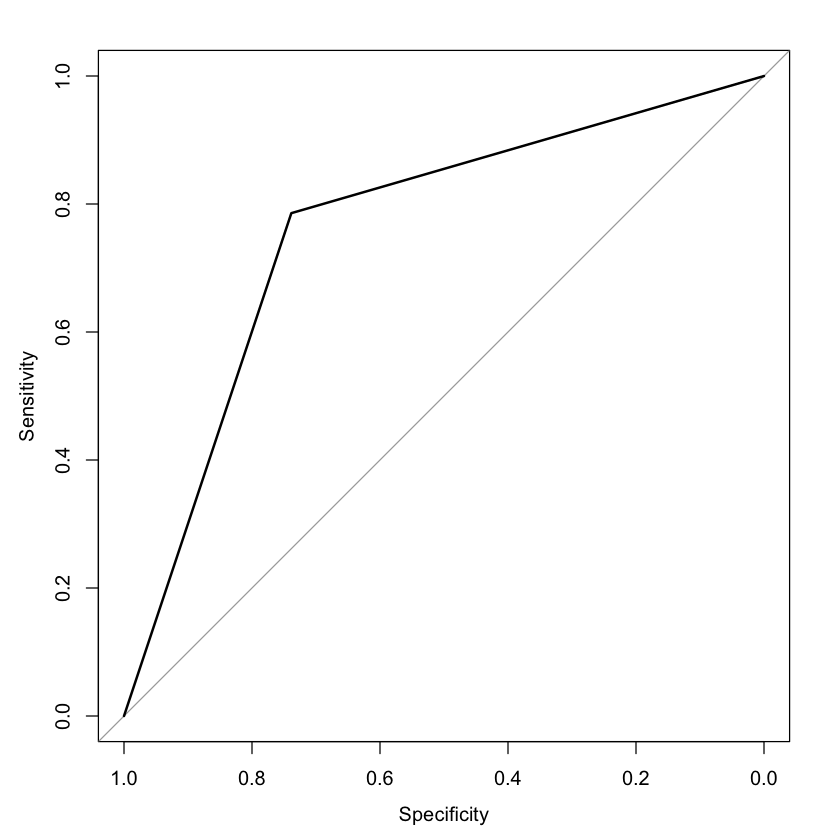

In [28]:
roc_lda <-roc(test.data$alcabuse,predicted.classes, ci=T, plot = T)
roc_lda
ci(roc_lda)

#### I'm enclosing the data for 300+ young people who completed the Resiliency Survey.  It is divided into six subscales listed below.  Does a factor analysis support the division into those six subscales.  I'm also enclosing the actual questions.  They are labeled "Youth 1 -43" and there is a break in the middle.  You can use those questions to think about the factor structure.  There is a small bit of missing data which you can take care of.

Resiliency Survey
We are trying to understand the properties of a new survey of resiliency factors in youth. I've attached the data set(resiliency_class.csv).  There are 43 questions and 6 subscales.

The subscales are as follows:
    Involvement Q1-6
    Social skills Q7-12
    Family strengths Q13-23
    School strengths Q24-29
    Social supports Q30-37
    Positive Outlooks Q38-43

The survey is embedded in a larger survey (Stress and Resources Survey) also attached.

In [37]:
res = read.csv('data_files//resiliency_class.csv')
dim(res)
res = na.omit(res)
dim(res)
head(res)

[1] 350  50

[1] 300  50

,YOUTH1,YOUTH2,YOUTH3,YOUTH4,YOUTH5,YOUTH6,YOUTH7,YOUTH8,YOUTH9,YOUTH10,...,YOUTH41,YOUTH42,YOUTH43,INVOLVEMENT,SOCIAL_SKILLS,FAMILY_STRENGTH,SCHOOL_STRENGTH,SOCIAL_SUPPORT,POSITIVE_OUTLOOK,TOTAL_RESILIENCY
2,3,5,1,1,1,3,3,3,5,5,...,2,4,2,14,24,28,10,12,14,102
3,2,1,5,1,3,1,4,4,4,4,...,4,4,4,13,21,33,18,26,10,121
4,4,1,1,1,3,2,4,3,4,5,...,3,3,3,12,23,33,11,20,13,112
5,5,2,1,3,3,3,3,5,3,5,...,3,4,3,17,22,44,17,28,17,145
6,1,1,1,3,4,3,4,4,4,5,...,2,4,4,13,24,35,18,26,18,134
7,4,1,1,1,2,3,4,3,5,5,...,4,4,4,12,24,43,18,36,19,152


In [57]:
# grab data only for cor matrix
res.dat = res[,1:43]
dim(res.dat)

[1] 300  43

In [60]:
# check if measurements on same scales, they are
apply(res.dat,2,max)

YOUTH1  YOUTH2  YOUTH3  YOUTH4  YOUTH5  YOUTH6  YOUTH7  YOUTH8  YOUTH9 YOUTH10 
      5       5       5       5       5       5       5       5       5       5 
YOUTH11 YOUTH12 YOUTH13 YOUTH14 YOUTH15 YOUTH16 YOUTH17 YOUTH18 YOUTH19 YOUTH20 
      5       5       4       4       4       4       4       4       4       4 
YOUTH21 YOUTH22 YOUTH23 YOUTH24 YOUTH25 YOUTH26 YOUTH27 YOUTH28 YOUTH29 YOUTH30 
      4       4       4       4       4       4       4       4       4       4 
YOUTH31 YOUTH32 YOUTH33 YOUTH34 YOUTH35 YOUTH36 YOUTH37 YOUTH38 YOUTH39 YOUTH40 
      4       4       4       4       4       4       4       4       4       4 
YOUTH41 YOUTH42 YOUTH43 
      4       4       4

In [61]:
cormat = cor(res.dat)

In [63]:
full.fit <- principal(cormat, nfactors=6, rotate = "none")
print(full.fit)

Principal Components Analysis
Call: principal(r = cormat, nfactors = 6, rotate = "none")
Standardized loadings (pattern matrix) based upon correlation matrix
         PC1   PC2   PC3   PC4   PC5   PC6   h2   u2 com
YOUTH1  0.39  0.15  0.03  0.18  0.20  0.25 0.31 0.69 3.2
YOUTH2  0.17  0.21  0.05  0.13  0.35  0.34 0.33 0.67 3.5
YOUTH3  0.11  0.14  0.34  0.38  0.36 -0.05 0.43 0.57 3.5
YOUTH4  0.09  0.27  0.35  0.55  0.13 -0.08 0.53 0.47 2.5
YOUTH5  0.24  0.34  0.12  0.24  0.30  0.24 0.40 0.60 4.8
YOUTH6  0.23  0.31 -0.09 -0.05  0.31  0.15 0.28 0.72 3.5
YOUTH7  0.44  0.15  0.49 -0.14 -0.29 -0.15 0.59 0.41 3.3
YOUTH8  0.43  0.10  0.36 -0.12 -0.21 -0.06 0.38 0.62 2.8
YOUTH9  0.47  0.16  0.39 -0.14 -0.30 -0.20 0.54 0.46 3.6
YOUTH10 0.41  0.15  0.17 -0.11 -0.17 -0.19 0.30 0.70 2.7
YOUTH11 0.40  0.36  0.18  0.01  0.12 -0.28 0.41 0.59 3.4
YOUTH12 0.36  0.34  0.45 -0.06 -0.18 -0.04 0.49 0.51 3.3
YOUTH13 0.22 -0.12  0.09  0.01 -0.07 -0.18 0.11 0.89 3.2
YOUTH14 0.51 -0.31 -0.07  0.33 -0.30  0.13 0

Warning message in fa.parallel(cormat):
“It seems as if you are using a correlation matrix, but have not specified the number of cases. The number of subjects is arbitrarily set to be 100  ”

Parallel analysis suggests that the number of factors =  4  and the number of components =  4 


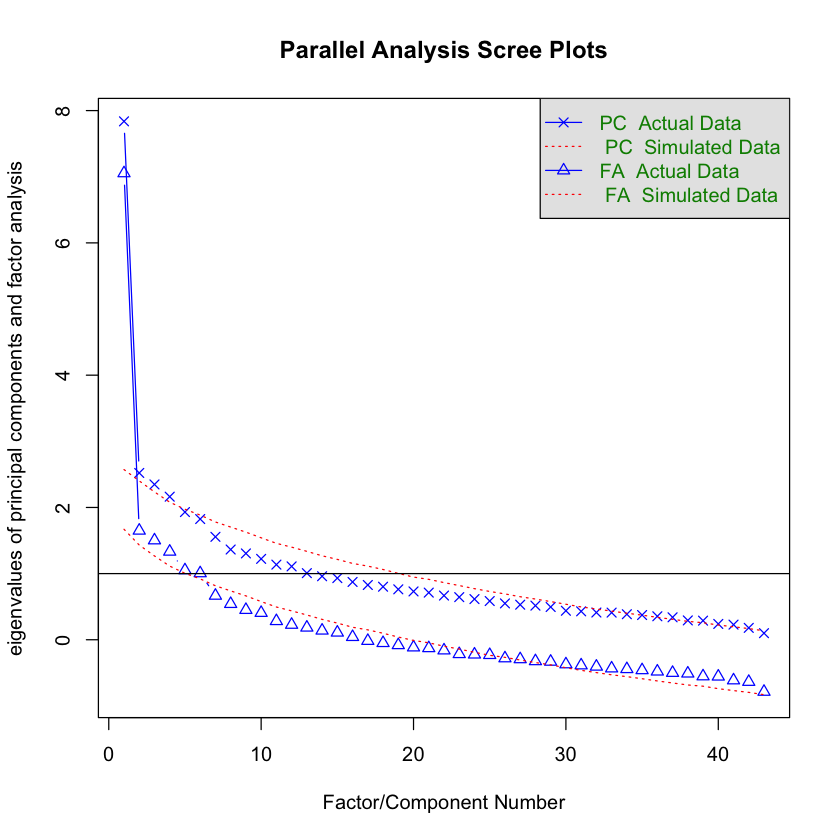

In [64]:
fa.parallel(cormat)

In [106]:
pca_rot <- principal(cormat, nfactors=6, rotate = "varimax")
print.psych(pca_rot)

Principal Components Analysis
Call: principal(r = cormat, nfactors = 6, rotate = "varimax")
Standardized loadings (pattern matrix) based upon correlation matrix
          RC1   RC3   RC4   RC6   RC5   RC2   h2   u2 com
YOUTH1   0.11  0.09  0.11  0.20  0.48  0.04 0.31 0.69 1.7
YOUTH2  -0.06 -0.05  0.07  0.03  0.56  0.04 0.33 0.67 1.1
YOUTH3   0.11  0.13 -0.38 -0.06  0.46  0.21 0.43 0.57 2.7
YOUTH4   0.12  0.23 -0.53  0.04  0.42 -0.01 0.53 0.47 2.5
YOUTH5   0.03  0.10 -0.04  0.03  0.62 -0.04 0.40 0.60 1.1
YOUTH6   0.09  0.01  0.24 -0.13  0.44 -0.06 0.28 0.72 1.9
YOUTH7   0.02  0.75  0.05  0.10 -0.02  0.09 0.59 0.41 1.1
YOUTH8   0.03  0.59  0.11  0.13  0.03  0.09 0.38 0.62 1.2
YOUTH9   0.11  0.71  0.09  0.09 -0.04  0.04 0.54 0.46 1.1
YOUTH10  0.20  0.49  0.14  0.04  0.00  0.00 0.30 0.70 1.5
YOUTH11  0.33  0.45  0.03 -0.18  0.26  0.00 0.41 0.59 2.9
YOUTH12 -0.03  0.67  0.01  0.02  0.18 -0.05 0.49 0.51 1.2
YOUTH13  0.18  0.19  0.00  0.09 -0.10  0.14 0.11 0.89 3.9
YOUTH14  0.27  0.11  0.03  

In [107]:
x = as.data.frame(pca_rot$loadings[,])

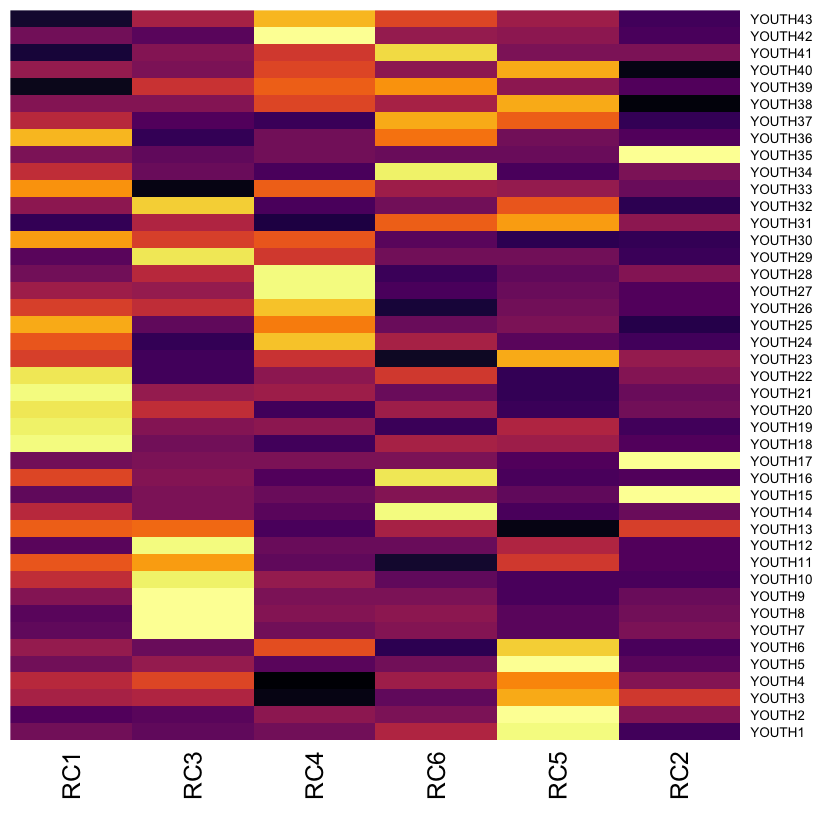

In [139]:
heatmap(data.matrix(x), col=inferno(50),Colv = NA, Rowv = NA)